# Load the Data

I decided to fit the model only with sub1 (subject1) due to the size of the data.
It would be too much time consuming doing cross-valiadation with all the data.
On a "normal enviroment" I would probably try to fit the model and build the cross-validation inside of AWS SageMaker for instance.

In [ ]:
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn

In [32]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold

In [4]:
def union_xlsx_files(folder_path):
    # List to store DataFrames
    dataframes = []
    
    # Walk through the folder structure
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.xlsx'):
                file_path = os.path.join(root, file)
                # Read the Excel file and append to the list
                dataframes.append(pd.read_excel(file_path))
    
    # Concatenate all DataFrames
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

# Example usage
folder_path = './Data/sub1/ADLs/'  # Replace with your folder path
df_ADLs = union_xlsx_files(folder_path)

folder_path = './Data/sub1/Falls/'
df_Falls = union_xlsx_files(folder_path)

folder_path = './Data/sub1/Near_Falls/'
df_Near_Falls = union_xlsx_files(folder_path)

In [30]:
print(df_ADLs.shape)
print(df_Falls.shape)
print(df_Near_Falls.shape)

(49305, 65)
(40343, 65)
(28815, 65)


# Data Preprocessing

In [31]:
# Add a label column to each DataFrame
df_ADLs['label'] = 'OK'
df_Falls['label'] = 'Fall'
df_Near_Falls['label'] = 'Near_Fall'

# Concatenate all DataFrames into one
df_combined = pd.concat([df_ADLs, df_Falls, df_Near_Falls], ignore_index=True)
df_combined.sample(5)

,Time,r.ankle Acceleration X (m/s^2),r.ankle Acceleration Y (m/s^2),r.ankle Acceleration Z (m/s^2),r.ankle Angular Velocity X (rad/s),r.ankle Angular Velocity Y (rad/s),r.ankle Angular Velocity Z (rad/s),r.ankle Magnetic Field X (uT),r.ankle Magnetic Field Y (uT),r.ankle Magnetic Field Z (uT),...,waist Acceleration X (m/s^2),waist Acceleration Y (m/s^2),waist Acceleration Z (m/s^2),waist Angular Velocity X (rad/s),waist Angular Velocity Y (rad/s),waist Angular Velocity Z (rad/s),waist Magnetic Field X (uT),waist Magnetic Field Y (uT),waist Magnetic Field Z (uT),label
104645,1304795520632810,-8.438113,1.011413,-1.912057,-0.096124,-0.257633,0.377652,50.811200,15.966487,-3.158374,...,-7.691897,2.369121,0.155150,0.055306,0.546575,-0.421284,41.801679,-32.429046,-30.318697,Near_Fall
13172,1304799290000000,-9.528618,-0.895205,-2.181140,0.217971,0.051539,-0.015491,28.649130,22.612795,27.222936,...,-9.566462,-0.359878,2.386942,0.150633,1.066192,-0.011376,36.303574,-49.095314,-7.480555,OK
48465,1304800996484370,0.632913,-16.246476,-4.042176,0.248225,0.217100,-0.811460,59.752881,40.706806,66.474259,...,-12.935631,-0.661563,-5.520982,-0.312779,1.296656,-0.076932,41.092558,-45.288357,-50.102262,OK
36908,1304799746140620,-6.388639,7.947188,-2.991828,-1.047670,-0.467416,0.829276,43.300042,-22.450089,19.357911,...,-6.032296,-0.339329,-8.794696,-0.546829,-0.578218,-0.321597,29.354222,-15.294931,-46.371482,OK
15074,1304799659554680,-9.652585,-0.193680,-1.756593,0.218070,0.053922,-0.009197,47.503376,20.292138,12.131121,...,-9.848752,0.174948,-0.410553,0.145725,1.101736,-0.047058,37.231803,-31.206354,-27.615233,OK


Low-variance features: []


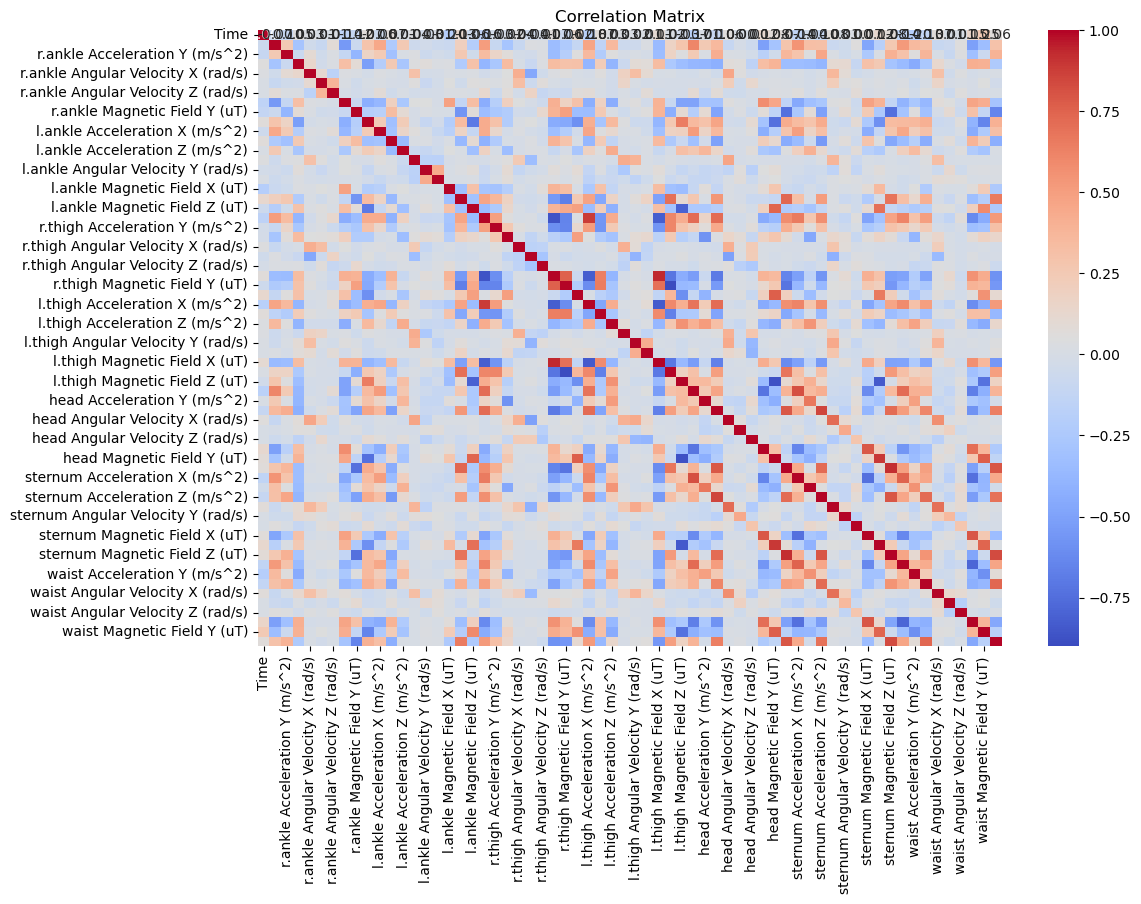

Highly correlated features: ['l.thigh Magnetic Field X (uT)', 'l.thigh Magnetic Field Y (uT)', 'sternum Magnetic Field Z (uT)']


In [47]:
numeric_columns = df_combined.select_dtypes(include=['float64', 'int64']).columns

# Step 1: Calculate variance and drop low-variance features
variance_threshold = 0.01  # Adjust threshold as needed
low_variance_features = df_combined[numeric_columns].var()[df_combined[numeric_columns].var() < variance_threshold].index
print(f"Low-variance features: {list(low_variance_features)}")
df_combined.drop(columns=low_variance_features, inplace=True)

# Step 2: Calculate correlation matrix
correlation_matrix = df_combined[numeric_columns].corr()

# Step 3: Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Step 4: Drop highly correlated features
correlation_threshold = 0.9  # Adjust threshold as needed
highly_correlated = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated.add(colname)

print(f"Highly correlated features: {list(highly_correlated)}")
df_combined.drop(columns=highly_correlated, inplace=True)

In [58]:
numeric_columns = df_combined.select_dtypes(include=['float64', 'int64']).columns

# Step 1: Handle missing values
df_combined[numeric_columns] = df_combined[numeric_columns].fillna(df_combined[numeric_columns].mean())

# Step 2: Standardize numeric columns
scaler = StandardScaler()
df_combined[numeric_columns] = scaler.fit_transform(df_combined[numeric_columns])

# Step 3: Create new features
df_combined['rolling_mean'] = df_combined[numeric_columns[0]].rolling(window=3).mean()
df_combined['value_diff'] = df_combined[numeric_columns[0]].diff()

# Fill NaN values created by rolling and diff
df_combined.fillna(0, inplace=True)

# Function to create sequences with labels
def create_sequences(data, label_col='label', window_size=5, step=1):
    X, y = [], []
    features = data.drop(columns=[label_col]).values
    labels = data[label_col].values
    for i in range(0, len(data) - window_size, step):
        window_features = features[i:i+window_size]
        window_label = pd.Series(labels[i:i+window_size]).mode()[0]
        X.append(window_features)
        y.append(window_label)
    return np.array(X), np.array(y)

# Step 4: Create sequences for LSTM
window_size = 10  # Example sequence length
step = 1  # Step size for sliding window
X, y = create_sequences(df_combined, label_col='label', window_size=window_size, step=step)

/Users/kuasney/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kuasney/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check 

# Model

In [64]:
# Encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 1: Split the data into train, test, and unseen sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)
X_test, X_unseen, y_test, y_unseen = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 2: Perform k-fold cross-validation on the train set
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_index, val_index in kf.split(X_train):
    print(f"Fold {fold}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define and compile the model
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(len(set(y_encoded)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=32,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
        verbose=0
    )

    # Evaluate on the validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    fold += 1

Fold 1


/Users/kuasney/miniconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 0.0050, Validation Accuracy: 0.9984
Fold 2
Validation Loss: 0.0058, Validation Accuracy: 0.9982
Fold 3
Validation Loss: 0.0088, Validation Accuracy: 0.9972
Fold 4
Validation Loss: 0.0046, Validation Accuracy: 0.9991
Fold 5
Validation Loss: 0.0018, Validation Accuracy: 0.9994


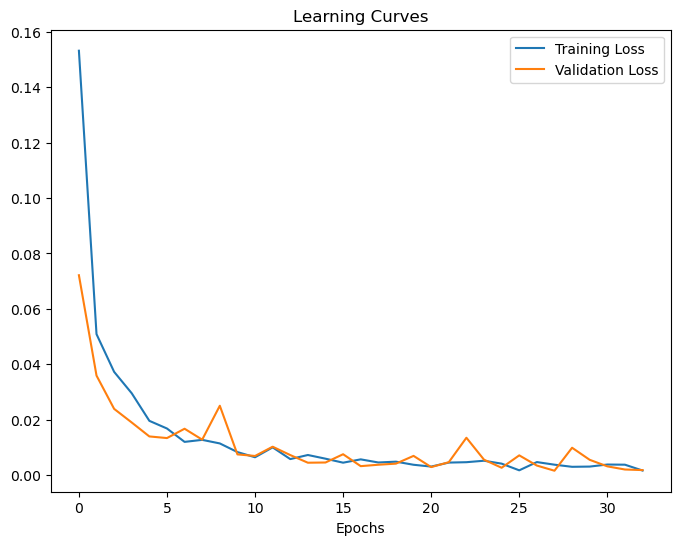

In [71]:
# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Evaluation

In [72]:
# Step 3: Evaluate the model on the test set
y_test_pred = np.argmax(model.predict(X_test), axis=1)
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

# Step 4: Test the model on unseen data
y_unseen_pred = np.argmax(model.predict(X_unseen), axis=1)
print("Unseen Data Classification Report:")
print(classification_report(y_unseen, y_unseen_pred))

741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8033
           1       1.00      1.00      1.00      5722
           2       1.00      1.00      1.00      9936

    accuracy                           1.00     23691
   macro avg       1.00      1.00      1.00     23691
weighted avg       1.00      1.00      1.00     23691

741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Unseen Data Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8173
           1       1.00      1.00      1.00      5707
           2       1.00      1.00      1.00      9811

    accuracy                           1.00     23691
   macro avg       1.00      1.00      1.00     23691
weighted avg       1.00      1.00      1.00     23691


In [73]:
# Step 2: Classification Report
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred))


741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8033
           1       1.00      1.00      1.00      5722
           2       1.00      1.00      1.00      9936

    accuracy                           1.00     23691
   macro avg       1.00      1.00      1.00     23691
weighted avg       1.00      1.00      1.00     23691


In [74]:
# Step 3: ROC Curve and AUC
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(set(y)))
y_pred_prob = model.predict(X_test)
roc_auc = roc_auc_score(y_test_one_hot, y_pred_prob, multi_class='ovr')
print(f"Overall AUC: {roc_auc:.2f}")

741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Overall AUC: 1.00


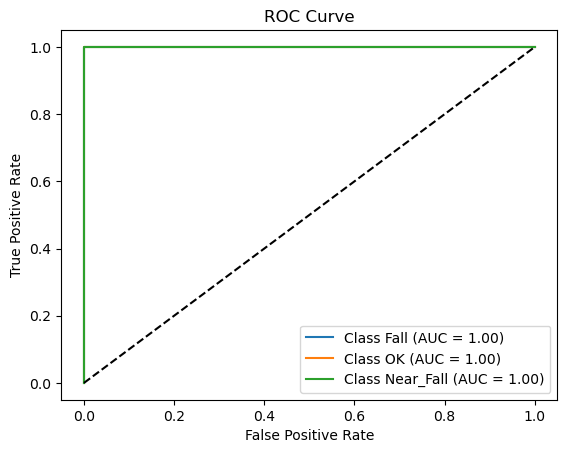

In [75]:
# Plot ROC Curve for each class
for i, class_label in enumerate(set(y)):
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc_score(y_test_one_hot[:, i], y_pred_prob[:, i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Trying to see why the score is "almost perfect"

## PCA - Principal Component Analysis

/Users/kuasney/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


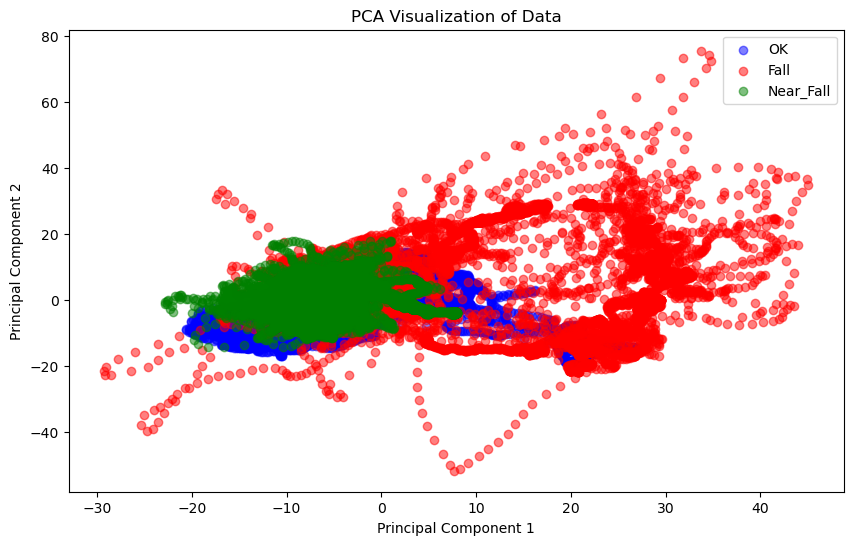

In [77]:
# Fit the LabelEncoder with all unique labels
label_encoder = LabelEncoder()
label_encoder.fit(df_combined['label'])  # Fit with all labels: 'OK', 'Fall', 'Near_Fall'

# Transform the labels in the dataset
y_encoded = label_encoder.transform(y)

# Reduce the data to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.reshape(X.shape[0], -1))  # Flatten the sequences for PCA

# Plot the PCA results
plt.figure(figsize=(10, 6))
for label, color in zip(['OK', 'Fall', 'Near_Fall'], ['blue', 'red', 'green']):
    plt.scatter(X_pca[y_encoded == label_encoder.transform([label])[0], 0],
                X_pca[y_encoded == label_encoder.transform([label])[0], 1],
                label=label, alpha=0.5, c=color)
plt.title('PCA Visualization of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## Histogram by Class

In [78]:
feature_index = 0
feature_name = numeric_columns[feature_index]

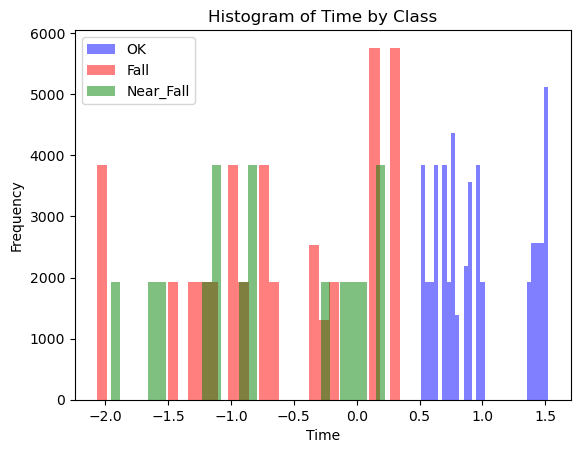

In [79]:
# Plot histograms for a specific feature
for label, color in zip(['OK', 'Fall', 'Near_Fall'], ['blue', 'red', 'green']):
    subset = df_combined[df_combined['label'] == label]
    plt.hist(subset[feature_name], bins=30, alpha=0.5, label=label, color=color)

plt.title(f'Histogram of {feature_name} by Class')
plt.xlabel(feature_name)
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Density Plot

/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

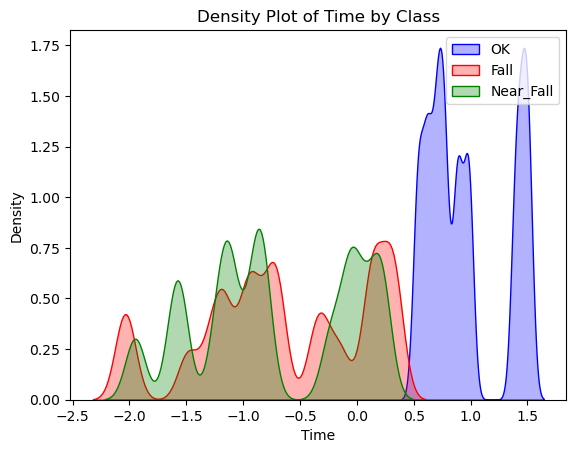

In [80]:
# Plot KDE for a specific feature
for label, color in zip(['OK', 'Fall', 'Near_Fall'], ['blue', 'red', 'green']):
    subset = df_combined[df_combined['label'] == label]
    sns.kdeplot(subset[feature_name], label=label, color=color, fill=True, alpha=0.3)

plt.title(f'Density Plot of {feature_name} by Class')
plt.xlabel(feature_name)
plt.ylabel('Density')
plt.legend()
plt.show()

# Boxplot

/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


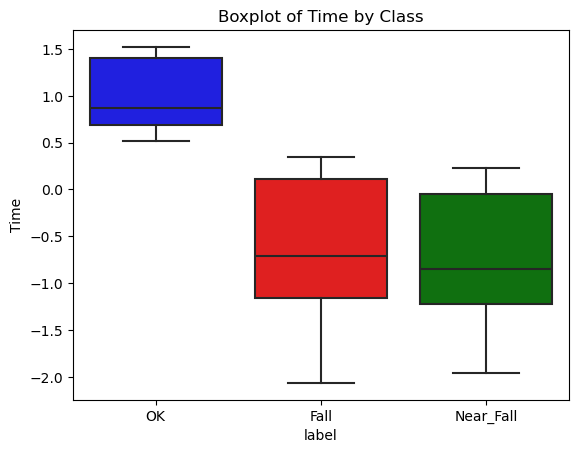

In [81]:
# Select a specific feature for visualization
feature_index = 0  # Change this to visualize other features
feature_name = numeric_columns[feature_index]

# Add the feature and label to a DataFrame
df_boxplot = pd.DataFrame({
    feature_name: df_combined[feature_name],
    'label': df_combined['label']
})

# Plot the boxplot
sns.boxplot(x='label', y=feature_name, data=df_boxplot, palette={'OK': 'blue', 'Fall': 'red', 'Near_Fall': 'green'})
plt.title(f'Boxplot of {feature_name} by Class')
plt.show()

# Violin Plot

/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kuasney/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


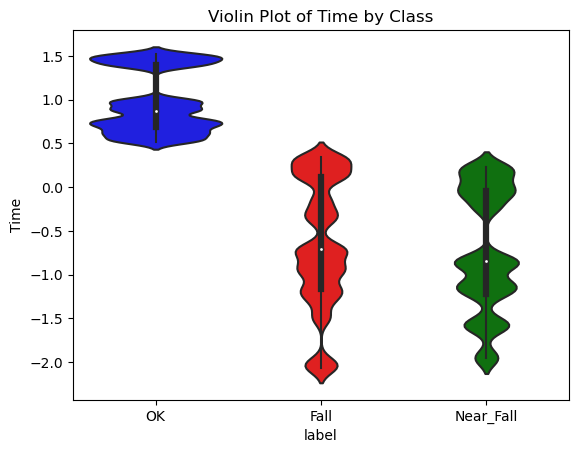

In [82]:
# Plot the violin plot
sns.violinplot(x='label', y=feature_name, data=df_boxplot, palette={'OK': 'blue', 'Fall': 'red', 'Near_Fall': 'green'})
plt.title(f'Violin Plot of {feature_name} by Class')
plt.show()

# Conclusion and What Would I Do

Training and validation loss converge quickly and go near zero → ✅ The model learns fast and generalizes well.
No sign of underfitting or overfitting → great optimization behavior.

Fall data is visually distinct, but Near Fall and OK overlap quite a bit.
Suggests the model may classify Fall very confidently, but might still confuse Near Fall with OK. (which is not happening, the model is predicting very well) → That's what I could spend way more time trying to improve and find a proper answer. I didn't find a good explanation for that and if I had mode time I would definetely dive into.

Regarding the box-plot chart
'OK' occurs at high standardized time values
'Fall' and 'Near Fall' occur at lower ones

This means Time alone is already a strong discriminative feature, which helps your model even before considering more complex sensor dynamics.

My model likely performs very well, but not because the full data is trivial. Instead:
Fall is separable — and the model likely nails that class.

Near Fall vs OK has some overlap — it’s a little trickier, and likely the only source of misclassification (but again, the model is separating very well, which in my opinion is little bit odd).

My LSTM benefits from both time-aware structure and clear signal in the features (like Time, PCA variance, etc).


What would I do next?

* If I remove Time, does the model still perform well?

* Would using attention or Transformer layers improve the interpretation of overlapping signals? (Just a test, because LSTM is already good)

* Spend more time trying to answer why the model is classifying very well "OK" and "Near Fall".

* Do more "basic analysis" at the beginning of the project to try to catch more info about the data.

* Also test less complex models to analyse the trade-off performance vs complexity.


